In [131]:
import ipywidgets as widgets
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import yfinance as yf

In [132]:
# Отрисовка свечного графика
def candles(ax, data, interval, alpha=1):
    coeff = {"1m":1/24/60, "2m":1/24/30, "5m":1/24/12, "15m":1/24/4, "30m":1/24/2,
        "60m":1/24, "90m":1/16, "1h":1/24, "1d":1, "5d":5, "1wk":7, "1mo":30,
         "3mo":90}
    up = data[data.Close >= data.Open]
    down = data[data.Close < data.Open]
    col_up = 'green'
    col_down = 'red'
    col_shadow_up = 'black'
    col_shadow_down = 'black'
    width_body = .8 * coeff[interval]
    width_shadow = .2 * coeff[interval]
    ax.bar(up.index, up.Close-up.Open, width_body, bottom=up.Open, color=col_up, alpha=alpha)
    ax.bar(up.index, up.High-up.Close, width_shadow, bottom=up.Close, color=col_shadow_up, alpha=alpha)
    ax.bar(up.index, up.Low-up.Open, width_shadow, bottom=up.Open, color=col_shadow_up, alpha=alpha)
    ax.bar(down.index, down.Close-down.Open, width_body, bottom=down.Open, color=col_down, alpha=alpha)
    ax.bar(down.index, down.High-down.Open, width_shadow, bottom=down.Open, color=col_shadow_down, alpha=alpha)
    ax.bar(down.index, down.Low-down.Close, width_shadow, bottom=down.Close, color=col_shadow_down, alpha=alpha)

In [133]:
# Получение данных
def get_data(ticker, period, interval):
    return yf.download(ticker, period=period, interval=interval)
data = get_data("BTC-USD", "1y", "1wk")

[*********************100%***********************]  1 of 1 completed


In [134]:
# Нахождение экстремумов
def get_points(data, n):
    resistance_points = data.iloc[scipy.signal.argrelextrema(data["High"].to_numpy(), np.greater, axis=0, order=n)]
    support_points = data.iloc[scipy.signal.argrelextrema(data["Low"].to_numpy(), np.less, axis=0, order=n)]
    return resistance_points, support_points
resistance_points, support_points = get_points(data, round(data.shape[0]/50))

In [135]:
# Определение линий тренда
def get_levels(data, resistance_points, support_points):
    levels = []
    for to_check in itertools.combinations(range(resistance_points.shape[0]), 3):
        info = np.polyfit(to_check, resistance_points.iloc[list(to_check)]["High"], 1, full=True)
        if info[1] < 1000:
            a = info[0][0]
            b = info[0][1]
            levels.append(((resistance_points.iloc[[to_check[0]]].index, resistance_points.iloc[[to_check[-1]]].index), 
                           (a*to_check[0]+b, a*to_check[-1]+b), 
                           "red"))
    for to_check in itertools.combinations(range(support_points.shape[0]), 3):
        info = np.polyfit(to_check, support_points.iloc[list(to_check)]["Low"], 1, full=True)
        if info[1] < 1000:
            a = info[0][0]
            b = info[0][1]
            levels.append(((support_points.iloc[[to_check[0]]].index, support_points.iloc[[to_check[-1]]].index), 
                           (a*to_check[0]+b, a*to_check[-1]+b), 
                           "green"))
    return levels
levels = get_levels(data, resistance_points, support_points)

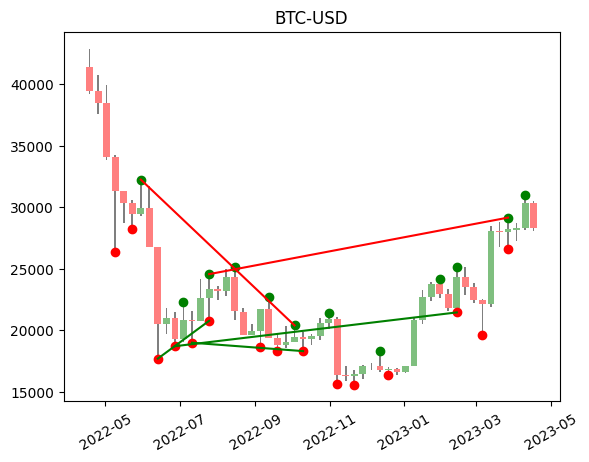

In [136]:
fig = plt.figure()
ax = fig.add_subplot()
candles(ax, data,"1wk", 0.5)
ax.scatter(resistance_points.index, resistance_points["High"], color="green")
ax.scatter(support_points.index, support_points["Low"], color="red")
for lvl in levels:
    ax.plot(lvl[0], lvl[1], c=lvl[2])
plt.title("BTC-USD")
plt.xticks(rotation=30)
plt.show()